# GNN Experiment
Implementing and evaluating a Graph Neural Network (GCN) on molecular graphs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import sys
import os
import torch

# Add src to path
sys.path.append(os.path.abspath('..'))

from src.models import GNNModel
from src.utils.metrics import calculate_metrics

# Set plots style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using device: cuda


## 2. Load Data

In [2]:
train_df = pd.read_csv('../data/raw/train.csv') # Load RAW data for SMILES
test_df = pd.read_csv('../data/raw/test.csv')

# Check for invalid SMILES or missing Tm? Usually assumed clean from raw for this comp.
X = train_df[['SMILES']]
y = train_df['Tm']
X_test = test_df[['SMILES']]

## 3. Train GNN with Cross-Validation

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

gnn_params = {
    'hidden_channels': 128,
    'learning_rate': 0.005,
    'batch_size': 64,
    'epochs': 100
}

fold_metrics = []
test_fold_preds = []
oof_preds = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold+1}/5")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = GNNModel(params=gnn_params)
    model.fit(X_train, y_train, X_val, y_val)
    
    val_pred = model.predict(X_val)
    oof_preds[val_idx] = val_pred
    
    metrics = calculate_metrics(y_val, val_pred)
    fold_metrics.append(metrics)
    print(f"Fold {fold+1} MAE: {metrics['MAE']:.4f}")
    
    test_fold_preds.append(model.predict(X_test))

avg_mae = np.mean([m['MAE'] for m in fold_metrics])
print(f"\nAverage CV MAE: {avg_mae:.4f}")

avg_preds = np.mean(test_fold_preds, axis=0)
submission = pd.DataFrame({'id': test_df['id'], 'Tm': avg_preds})
submission.to_csv('../submissions/submission_gnn.csv', index=False)
print("Saved GNN submission.")


Fold 1/5
Featurizing training graphs...
Featurizing validation graphs...
Training GNN on cuda...
Epoch 10, Loss: 62.6541
Epoch 20, Loss: 60.8045
Epoch 30, Loss: 59.3985
Epoch 40, Loss: 60.1243
Epoch 50, Loss: 60.1919
Epoch 60, Loss: 58.5562
Epoch 70, Loss: 57.5931
Epoch 80, Loss: 57.8591
Epoch 90, Loss: 58.2275
Epoch 100, Loss: 58.3052
Fold 1 MAE: 53.6050

Fold 2/5
Featurizing training graphs...
Featurizing validation graphs...
Training GNN on cuda...
Epoch 10, Loss: 62.4509
Epoch 20, Loss: 61.7383
Epoch 30, Loss: 61.1843
Epoch 40, Loss: 61.1100
Epoch 50, Loss: 59.9391
Epoch 60, Loss: 59.2903
Epoch 70, Loss: 59.8371
Epoch 80, Loss: 58.9537
Epoch 90, Loss: 57.6371
Epoch 100, Loss: 59.2395
Fold 2 MAE: 52.9025

Fold 3/5
Featurizing training graphs...
Featurizing validation graphs...
Training GNN on cuda...
Epoch 10, Loss: 63.1232
Epoch 20, Loss: 62.3990
Epoch 30, Loss: 60.7488
Epoch 40, Loss: 61.6579
Epoch 50, Loss: 60.1295
Epoch 60, Loss: 59.8435
Epoch 70, Loss: 60.8180
Epoch 80, Loss: 

## 4. Compare with Stacking Ensemble
Comparing the GNN performance against the previous best (Stacking).

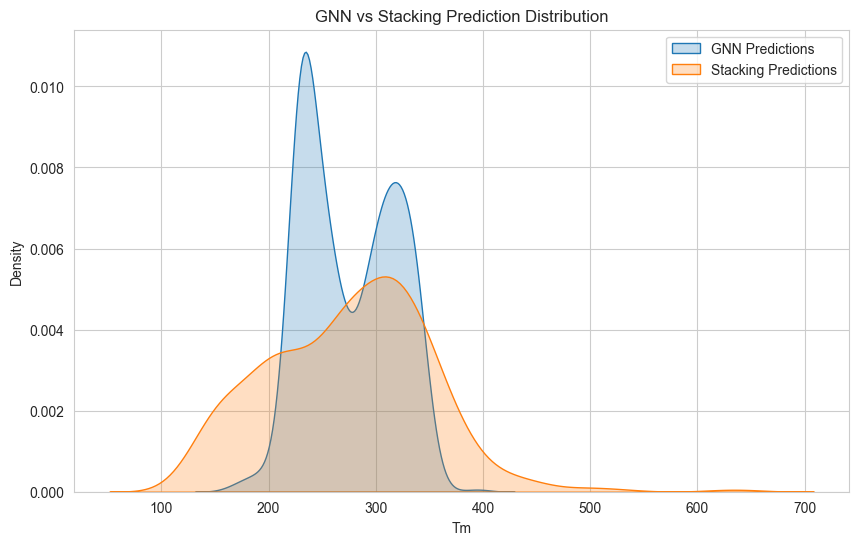

Correlation: 0.6039


In [4]:
try:
    stack_sub = pd.read_csv('../submissions/submission_stacking.csv')
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(submission['Tm'], label='GNN Predictions', fill=True)
    sns.kdeplot(stack_sub['Tm'], label='Stacking Predictions', fill=True)
    plt.title('GNN vs Stacking Prediction Distribution')
    plt.legend()
    plt.show()
    
    corr = np.corrcoef(submission['Tm'], stack_sub['Tm'])[0, 1]
    print(f"Correlation: {corr:.4f}")
    
    # Optional: Weighted Blend of Stacking + GNN
    blend = 0.9 * stack_sub['Tm'] + 0.1 * submission['Tm'] # GNN is likely weaker, give it small weight
    
except FileNotFoundError:
    print("Stacking submission not found.")